In [ ]:
print("starting")

import networkx as nx
import metis

print("Imported Metis")

G = nx.Graph()
G.add_node(1) 
G.add_nodes_from([2, 3])
H = nx.path_graph(10)
G.add_nodes_from(H)
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)  # unpack edge tuple*
G.add_edges_from([(1, 2), (1, 3)])
G.add_node(1)
G.add_edge(1, 2)
G.add_node("spam")        # adds node "spam"
G.add_nodes_from("spam")  # adds 4 nodes: 's', 'p', 'a', 'm'
G.add_edge(3, 'm')
print(G.number_of_nodes())
print(G.number_of_edges())
print(list(G.edges))

Error: Session cannot generate requests

In [ ]:
G = nx.erdos_renyi_graph(100, 0.0808080808, 1)
print(G)
metisG = metis.networkx_to_metis(G)
max_budget = 400
partition = 1
edgecuts = 0
edgecut_budget = []
Y2 = []
while (edgecuts < max_budget):
  (edgecuts, parts) = metis.part_graph(metisG, partition)
  if (edgecuts < max_budget):
    print(partition)
    edgecut_budget.append(edgecuts)
    cluster_sizes = {}
    for num in parts:
      if num not in cluster_sizes:
        cluster_sizes[num] = 0
      cluster_sizes[num] += 1
    max = 0
    for num in cluster_sizes:
      if cluster_sizes[num] > max:
        max = cluster_sizes[num]
    Y2.append(max)
  partition += 1
    
plt.plot(budgets, Y, label="Spectral Cut-Based Edge Removal")
plt.plot(edgecut_budget, Y2, label="Spectral Cut-Based Edge Removal")

plt.xlabel("Edge Budget")
plt.ylabel("Infection Size")
plt.title("Erdos Renyi (100 nodes, 400 edges)")
plt.legend()

Error: Session cannot generate requests

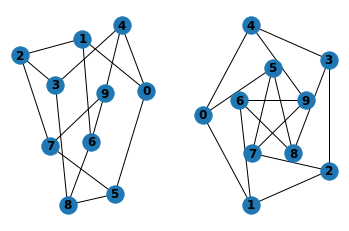

In [42]:
import matplotlib.pyplot as plt

G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [ ]:
import metis
import networkx
import pydot

graph = nx.erdos_renyi_graph(100, 0.0808080808, 1)
print(graph)
G = metis.networkx_to_metis(graph)
(edgecuts, parts) = metis.part_graph(G, 3)
print((edgecuts, parts))


Error: Session cannot generate requests

In [44]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import scipy.linalg as la

def tuples_to_dict(graph, N):
  graph_dict = {}
  for i in range(N):
    graph_dict[i] = []
  for edge in graph:
    graph_dict[edge[0]].append(edge[1])
  return graph_dict

def find_degrees(graph_dict, node_list):
  degs = []
  for i in node_list:
    degs.append(len(graph_dict[i]))
  return degs

def node_index(node, node_list):
  for index in range(len(node_list)):
    if (node_list[index] == node):
      return index

def graph_to_laplacian(graph_dict, node_list):
  # graph_dict = tuples_to_dict(graph, node_list)
  D = find_degrees(graph_dict, node_list)
  L = np.diag(D)
  for node in graph_dict:
      for neighbor in graph_dict[node]:
        L[node_index(node, node_list)][node_index(neighbor, node_list)] = -1
        L[node_index(neighbor, node_list)][node_index(node, node_list)] = -1
  return L

def graph_to_A(graph_dict, node_list):
  # graph_dict = tuples_to_dict(graph, node_list)
  N = len(graph_dict)
  A = np.zeros((N, N))
  for node in graph_dict:
      for neighbor in graph_dict[node]:
        A[node_index(node, node_list)][node_index(neighbor, node_list)] = 1
        A[node_index(neighbor, node_list)][node_index(node, node_list)] = 1
  return A

def calculate_M(node_list, N):
  M = np.zeros((N, N))
  for s in node_list:
    for t in node_list:
      if s != t:
        e_s = np.zeros(N)
        e_s[s] = 1
        e_t = np.zeros(N)
        e_t[t] = 1
        M += (e_s - e_t) @ (e_s - e_t).T
  return M

def dict_to_tuples(graph_dict):
  graph = []
  for u in graph_dict:
    for v in graph_dict[u]:
      graph.append([u,v])
  return graph

def effective_edge_resistance(graph_dict, N, edge_budget):
  edges_removed = 0
  node_list = [i for i in range(N)]
  M = calculate_M(node_list, N)
  while edges_removed < edge_budget:
    L = graph_to_laplacian(graph_dict, node_list)
    L_inv = np.linalg.pinv(L)
    edge_resistances = {}
    for u in graph_dict:
      e_u = np.zeros(N)
      e_u[u] = 1
      for v in graph_dict[u]:
        e_v = np.zeros(N)
        e_v[v] = 1
        edge_resistances[(u,v)] = (e_u - e_v).T @ L_inv @ M @ L_inv @ (e_u - e_v)
    # print(len(edge_resistances))
    removed_edge = max(edge_resistances, key=edge_resistances.get)
    graph_dict[removed_edge[0]].remove(removed_edge[1])
    graph_dict[removed_edge[1]].remove(removed_edge[0])
    edges_removed += 1
  
  return graph_dict


In [45]:
def percolation(neighbors_per_node, transmissionRate, recoveryRate):
    newGraph = []
    for node in neighbors_per_node:
        recoveryTime = np.random.exponential(1/recoveryRate)
        for neighbor in neighbors_per_node[node]:
            transmissionTime = np.random.exponential(1/transmissionRate)
            if (transmissionTime <= recoveryTime):
                newGraph.append([node, neighbor])
    return newGraph  

def find_connected_nodes(node, graph_dict, connected_component):
  if node not in connected_component:
    connected_component.append(node)
  for neighbor in graph_dict[node]:
    if neighbor not in connected_component:
      find_connected_nodes(neighbor, graph_dict, connected_component)

def find_entire_connection(infected_nodes, neighbors_per_node):
  connected_nodes = []
  for node in infected_nodes:
    find_connected_nodes(node, neighbors_per_node, connected_nodes)
  return connected_nodes

def calculateFinalInfection(graph_dict, N, numOfTrials, transmissionRate, recoveryRate):
  num_infected = []
  for i in range(numOfTrials):
    # print(i)
    graph = percolation(graph_dict, transmissionRate, recoveryRate)
    neighbors_per_node = tuples_to_dict(graph, N)
    infected_nodes = find_entire_connection(random.sample([i for i in range(0, N)], 1), neighbors_per_node)
    num_infected.append(len(infected_nodes))
  return np.mean(num_infected)

def erdos_renyi_graph(N, M):
  graph = []
  node_list = [i for i in range(N)]
  numEdges = 0
  while numEdges < M:
    edge = random.sample(node_list, 2)
    edge2 = [edge[1], edge[0]]
    if edge not in graph:
      numEdges += 1
      graph.append(edge)
      graph.append(edge2)
  return graph

def config_model2(deg_dist, n):
  node_list = np.arange(n)
  degreeOfNodes = {}
  for key in deg_dist:
    num_nodes = int(round(deg_dist[key]*n))
    nodes = node_list[:num_nodes]
    for node in nodes:
      degreeOfNodes[node] = key
    node_list = node_list[num_nodes:]
  sum_degs = 0
  for key in deg_dist:
    sum_degs += key*n*deg_dist[key]
  numedges = sum_degs/2
  half_edges = []
  for node in degreeOfNodes:
    deg = degreeOfNodes[node]
    for i in range(deg):
      half_edges.append(node)
  graph = []
  while half_edges != []:
    node1 = np.random.choice(half_edges)
    node2 = np.random.choice(half_edges)

    if (node1 != node2 and [node1, node2] not in graph):
      graph.append([node1, node2])
      graph.append([node2, node1])
      half_edges.remove(node1)
      half_edges.remove(node2)
  return graph


In [46]:
import heapq as hpq
import random
def random_edge_removal(graph, edge_budget):
  edges = random.sample(graph, edge_budget)
  # print (edges)
  all_edges = []
  for edge in edges:
    if edge not in all_edges:
      all_edges.append(edge)
      all_edges.append([edge[1], edge[0]])
    # if [edge[1], edge[0]] not in all_edges:
      # all_edges.append([edge[1], edge[0]])
  print (len(all_edges))
  new_graph = []
  for edge in graph:
    if edge not in all_edges:
      new_graph.append(edge)
  return new_graph

def tuples_to_dict(graph, N):
  graph_dict = {}
  for i in range(N):
    graph_dict[i] = []
  for edge in graph:
    graph_dict[edge[0]].append(edge[1])
  return graph_dict

# When I look into the toal degree of an edge from both side,
# and remove edges with the highest degree,
# this is not necessarily "proportional" I think
# it just cuts down the edges with extreme degrees
def highest_degree_edge_removal(graph_dict, edge_budget):
  degEdgeDict = {}
  for edge in graph:
    degEdgeDict[edge] = len(graph_dict[edge[0]]) + len(graph_dict[edge[0]]) - 2
  i = 0
  edges_to_remove = []
  while (i < edge_budget):
    edge1 = max(degEdgeDict, key=degEdgeDict.get)
    degEdgeDict[edge1] -= 1
    edge2 = [edge1[1], edge1[0]]
    degEdgeDict[edge2] -= 1
    edges_to_remove.append(edge1)
    edges_to_remove.append(edge2)
    i += 1
  new_graph = []
  for edge in graph:
    if edge != edges_to_remove:
      new_graph.append(edge)
  return tuples_to_dict(new_graph)

def dict_to_tuples(graph_dict):
  graph = []
  for u in graph_dict:
    for v in graph_dict[u]:
      graph.append([u,v])
  return graph

# the only way I could remove the edges was to remove half edges, because when I remove a full edge,
# that affects the degree proprotion of the other side too – I don't know how to do this
def degree_proportional_half_edge_removal(graph_dict, edge_budget):
  degDict = {}
  sum = 0
  for node in graph_dict:
    degDict[node] = len(graph_dict[node])
    sum += len(graph_dict[node])
  new_graph_dict = {}
  for node in graph_dict:
    # edge budget shoulbe multiplied by 2 to compensate for half edge removal
    num = round((degDict[node] / sum) * 2 * edge_budget) # gives the number of edges to remove from this node
    new_graph_dict[node] = random.sample(graph_dict[node], len(graph_dict[node]) - sum) 
    # len(graph_dict[node]) - sum is the number of remaning edges of this node after removal
  return new_graph_dict

def cut_size(A, left, right):
  size = np.sum(A[left].T[right])
  return size

# Makes single largest cut in graph (doesn't use full budget)
def biggest_cut_edge_removal(graph_dict, edge_budget):
  N = len(graph_dict)
  L = graph_to_laplacian(graph_dict, [i for i in range(N)])
  A = graph_to_A(graph_dict, [i for i in range(N)])
  results = la.eig(L)
  eigvalues = results[0]
  eigvectors = results[1]
  idx = eigvalues.argsort()[::-1]
  eigvectors = eigvectors[:,idx]  
  second_smallest_vec = eigvectors[:, -2]
  vec = second_smallest_vec.T
  ids = vec.argsort()[::-1]
  best_left = []
  best_right = [i for i in range(N)]
  best_cut = 0

  for i in range(int(N/2)):
    left = ids[:i]
    right = ids[i:]
    cut = cut_size(A, left, right)
    if cut > edge_budget:
      break
    best_cut = cut
    best_left = left
    best_right = right
  print("Cutting off %s nodes with %s edges out of %s" % (i, best_cut, edge_budget))

  new_graph = {}
  for i in range(N):
    new_graph[i] = []
    for edge_end in graph_dict[i]:
      if i in best_left and edge_end in best_left:
        new_graph[i].append(edge_end)
      elif i in best_right and edge_end in best_right:
        new_graph[i].append(edge_end)
  

  return new_graph, best_cut


def biggest_cut_edge_removal_recursive(graph_dict, edge_budget, node_list, components):
  N = len(graph_dict)
  
  # print (graph_dict)

  L = graph_to_laplacian(graph_dict, node_list)
  A = graph_to_A(graph_dict, node_list)
  results = la.eig(L)
  eigvalues = results[0]
  eigvectors = results[1]
  idx = eigvalues.argsort()[::-1]
  eigvectors = eigvectors[:,idx]  
  second_smallest_vec = eigvectors[:, -2]
  vec = second_smallest_vec.T
  ids = vec.argsort()[::-1]
  best_left = []
  best_right = node_list
  best_cut = 0

  for i in range(int(N/2)):
    left = []
    for id in ids[:i]:
      left.append(node_list[id])
    right = []
    for id in ids[i:]:
      right.append(node_list[id])
    # print (left)
    # print (right)
    cut = cut_size(A, ids[:i], ids[i:])
    if cut > edge_budget:
      break
    best_cut = cut
    best_left = left
    best_right = right
  print("Cutting off %s nodes with %s edges out of %s" % (i, best_cut, edge_budget))

  left_graph = {}
  right_graph = {}
  for i in node_list:
    for edge_end in graph_dict[i]:
      if i in best_left and edge_end in best_left:
        if i not in left_graph:
          left_graph[i] = []
        left_graph[i].append(edge_end)
      elif i in best_right and edge_end in best_right:
        if i not in right_graph:
          right_graph[i] = []
        right_graph[i].append(edge_end)

  hpq.heappush(components, (-len(right_graph), random.random() , right_graph))
  
  hpq.heappush(components, (-len(left_graph), random.random(), left_graph))


  if edge_budget > best_cut and len(best_left) > 0:
    component = hpq.heappop(components)[2]
    c_nodes = []
    for node in component:
      c_nodes.append(node)
    new_component, best_cut1 = biggest_cut_edge_removal_recursive(component, edge_budget - best_cut, c_nodes, components)
  # print (graph_dict)
  new_graph = left_graph.copy()
  new_graph.update(right_graph)

  return new_graph, best_cut

def merge(components):
  first = hpq.heappop(components)
  new_graph = first[2]
  for component in components:
    new_graph.update(component[2])
  return new_graph


def biggest_cut_edge_removal_greedy(graph_dict, edge_budget):
  N = len(graph_dict)
  L = graph_to_laplacian(graph_dict, [i for i in range(N)])
  A = graph_to_A(graph_dict, [i for i in range(N)])
  results = la.eig(L)
  eigvalues = results[0]
  eigvectors = results[1]
  idx = eigvalues.argsort()[::-1]
  eigvectors = eigvectors[:,idx]  
  second_smallest_vec = eigvectors[:, -2]
  vec = second_smallest_vec.T
  ids = vec.argsort()[::-1]
  best_left = []
  best_right = [i for i in range(N)]
  best_cut = 0

  for i in range(int(N/2)):
    left = ids[:i]
    right = ids[i:]
    cut = cut_size(A, left, right)
    if cut > edge_budget:
      break
    best_cut = cut
    best_left = left
    best_right = right
  print("Cutting off %s nodes with %s edges out of %s" % (i, best_cut, edge_budget))

  new_graph = {}
  for i in range(N):
    new_graph[i] = []
    for edge_end in graph_dict[i]:
      if i in best_left and edge_end in best_left:
        new_graph[i].append(edge_end)
      elif i in best_right and edge_end in best_right:
        new_graph[i].append(edge_end)
  # print (new_graph)
  if edge_budget > best_cut:
    new_graph = effective_edge_resistance(new_graph, N, edge_budget - best_cut)


  return new_graph, best_cut

graph = erdos_renyi_graph(100, 400)
graph_dict = tuples_to_dict(graph, 100)

components = []
# components.heappush(-len(graph_dict), graph_dict)
# biggest_cut_edge_removal_recursive(graph_dict, 50, [i for i in range(10)], components)
graph_dict = biggest_cut_edge_removal_greedy(graph_dict, 200)
print (graph_dict)
# print (merge(components))


Cutting off 49 nodes with 137.0 edges out of 200
({0: [40, 83, 70, 50, 84, 54, 41], 1: [23, 97, 17, 20, 73, 82, 6], 2: [76, 4, 30, 92, 46, 67], 3: [69, 28, 67], 4: [84, 2, 57], 5: [51, 37, 43, 6], 6: [51, 68, 58, 13, 1, 5, 56], 7: [], 8: [27, 12, 50, 71], 9: [67, 70, 72, 40], 10: [], 11: [], 12: [61, 8, 63, 60], 13: [88, 56, 82, 6, 33, 16], 14: [50, 28, 25], 15: [52, 22, 94, 73], 16: [64, 20, 43, 81, 91, 88, 32, 35, 38, 13], 17: [1, 91, 93, 68, 39, 58], 18: [39, 91, 43, 78, 23], 19: [], 20: [16, 78, 94, 1, 37, 52], 21: [], 22: [62, 68, 15, 89, 51], 23: [62, 1, 91, 97, 35, 36, 73, 18], 24: [], 25: [27, 96, 90, 14], 26: [], 27: [25, 90, 8, 84], 28: [54, 3, 30, 14, 69, 65], 29: [95, 40], 30: [96, 60, 28, 57, 2], 31: [], 32: [77, 16, 33, 68], 33: [58, 64, 91, 77, 51, 88, 37, 32, 13], 34: [51, 62, 78], 35: [23, 88, 16], 36: [23, 56, 38], 37: [86, 56, 5, 91, 20, 33], 38: [77, 58, 78, 86, 75, 36, 16], 39: [97, 18, 17], 40: [0, 29, 9], 41: [92, 0], 42: [], 43: [16, 78, 18, 5], 44: [], 45: [87,

In [55]:
import networkx as nx
import metis
import pydot

N = 100
M = 400
graph = erdos_renyi_graph(N, M)

original_graph = tuples_to_dict(graph, N)
budgets = []
numOfTrials = 200
transmissionRate = 0.9
recoveryRate = 0.1
Y = []
increment = 10
for i in range(1,40):
  print (i)
  budgets.append(increment*i)
  graph_dict_cut = biggest_cut_edge_removal_greedy(original_graph, budgets[-1])[0]
  Y.append(calculateFinalInfection(graph_dict_cut, N, numOfTrials, transmissionRate, recoveryRate))


1
Cutting off 3 nodes with 5.0 edges out of 10
2
Cutting off 5 nodes with 17.0 edges out of 20
3
Cutting off 6 nodes with 25.0 edges out of 30
4
Cutting off 8 nodes with 38.0 edges out of 40
5
Cutting off 9 nodes with 45.0 edges out of 50
6
Cutting off 11 nodes with 60.0 edges out of 60
7
Cutting off 13 nodes with 65.0 edges out of 70
8
Cutting off 15 nodes with 75.0 edges out of 80
9
Cutting off 17 nodes with 90.0 edges out of 90
10
Cutting off 21 nodes with 99.0 edges out of 100
11
Cutting off 23 nodes with 108.0 edges out of 110
12
Cutting off 31 nodes with 119.0 edges out of 120
13
Cutting off 34 nodes with 126.0 edges out of 130
14
Cutting off 39 nodes with 137.0 edges out of 140
15
Cutting off 49 nodes with 139.0 edges out of 150
16
Cutting off 49 nodes with 139.0 edges out of 160
17
Cutting off 49 nodes with 139.0 edges out of 170
18
Cutting off 49 nodes with 139.0 edges out of 180
19
Cutting off 49 nodes with 139.0 edges out of 190
20
Cutting off 49 nodes with 139.0 edges out o

Error: Session cannot generate requests

In [ ]:
import networkx as nx
import metis

G = nx.erdos_renyi_graph(100, 0.0808080808, 1)
print(G)
metisG = metis.networkx_to_metis(G)
max_budget = 400
partition = 1
edgecuts = 0
edgecut_budget = []
Y2 = []
while (edgecuts < max_budget):
  (edgecuts, parts) = metis.part_graph(metisG, partition)
  if (edgecuts < max_budget):
    print(partition)
    edgecut_budget.append(edgecuts)
    cluster_sizes = {}
    for num in parts:
      if num not in cluster_sizes:
        cluster_sizes[num] = 0
      cluster_sizes[num] += 1
    max = 0
    for num in cluster_sizes:
      if cluster_sizes[num] > max:
        max = cluster_sizes[num]
    Y2.append(max)
  partition += 1
    
plt.plot(budgets, Y, label="Spectral Cut-Based Edge Removal")
plt.plot(edgecut_budget, Y2, label="Spectral Cut-Based Edge Removal")

plt.xlabel("Edge Budget")
plt.ylabel("Infection Size")
plt.title("Erdos Renyi (100 nodes, 400 edges)")
plt.legend()

Error: Session cannot generate requests